- The Tensorflow model is an adaptation of the Keras example, Structured data classification from scratch, https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
#tf.enable_eager_execution()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
#import keras.backend as K

from keras.utils.generic_utils import get_custom_objects

from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup


import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import seaborn as sns
print ('Seaborn version: {}'.format(sns.__version__))

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks

!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]
NumPy version: 1.24.0
SciPy version:  1.9.3
TensorFlow version:  2.10.0
Keras version:  2.10.0
Pandas version:  1.5.2
Seaborn version: 0.12.1
SciKit-Learn version: 1.2.0
Imbalanced-Learn version: 0.10.0
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Finished Installing Packages


## Get Data

In [3]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed_All_12_22_22.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

## Thin Features

In [4]:
def Thin_Features(data):
    print ('Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
    ]
    
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

## Get Dummies

In [5]:
def Get_Dummies(data):
    print ('Get_Dummies')
    data = data.astype('category')
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
#    for feature in data_Dummies:
#        print (feature)
#    print ()
    return data_Dummies

def Test_Get_Dummies():
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A)
    display(C)

Test_Get_Dummies()

Get_Dummies


,A_a,A_b,B_a,B_b,B_c,C_1,C_2,C_3
0,1,0,0,1,0,1,0,0
1,0,1,1,0,0,0,1,0
2,1,0,0,0,1,0,0,1


## Test-Train Split
- We're using sklearn's train_test_split rather than Pandas's sample because the former has a 'stratify' option that will put the same proportion of HOSPITAL==1 into each set.

In [6]:
def Split_Data(data, target, test_size):
    print ()
    print ('Split_Data()')
    X = data.drop(columns=[target])
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=42
    )
    
    a = y_train[y_train==1].shape[0]
    b = y_test[y_test==1].shape[0]
    print (
        x_train.shape, 
        y_train.shape, a, round((a/(a+b)*100),2), '%')
    print (
        x_test.shape, 
        y_test.shape, b, round((b/(a+b)*100),2), '%'
    )
    print ()
    return x_train, x_test, y_train, y_test

## Convert from Pandas Dataframe to Tensorflow Dataset

In [7]:
def Dataframe_to_Dataset(dataframe, labels):
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

def Test_Dataframe_to_Dataset():
    dataframe = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
    })
    labels = pd.DataFrame({        
        'C': [1, 2, 3]
    })
    C = Dataframe_to_Dataset(dataframe, labels)
    print (list(C.as_numpy_iterator()))

Test_Dataframe_to_Dataset()


[({'A': b'a', 'B': b'b'}, array([1])), ({'A': b'a', 'B': b'c'}, array([3])), ({'A': b'b', 'B': b'a'}, array([2]))]


## Batch the Datasets

In [8]:
def Batch(ds):
    ds = ds.batch(32)
    return ds

def Test_Batch():
    dataset = tf.data.Dataset.range(100)
    dataset = Batch(dataset)
    display (list(dataset.as_numpy_iterator()))

Test_Batch()

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 array([96, 97, 98, 99])]

## Encode Features

In [9]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
#    print ('feature_ds')
#    print (feature_ds)
#    print (list(feature_ds.as_numpy_iterator()))
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

def Understand_Encode_Features():
    dataframe = pd.DataFrame({
        'A': [1,2,3], 
        'B': ['a', 'b', 'c'], 
    })
    labels = pd.DataFrame({        
        'C': [0,1,0]
    })
    display(dataframe)
    display(labels)
    print ()
    X = Dataframe_to_Dataset(dataframe, labels)
    print ('list(X.as_numpy_iterator())')
    print (list(X.as_numpy_iterator()))
    
    A = keras.Input(shape=(1,), name="A", dtype="int64")
    A_encoded = encode_categorical_feature(A, "A", X, False)

    B = keras.Input(shape=(1,), name="B", dtype="int64")
    B_encoded = encode_categorical_feature(B, "B", X, True) 

    all_inputs = [A,B]
    all_features = layers.concatenate([A_encoded,B_encoded])

    x = layers.Dense(32, activation="relu")(all_features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(all_inputs, output)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    display(model.summary())
    print (model.summary())

#Understand_Encode_Features()
    
def Encode_Features(df, ds):
    print ('Encode_Features()')
    Inputs = list(df.columns)
    print ('display(Inputs)')
#    display(Inputs)
    All_Inputs = []
    Features = []
    for i, input in enumerate (Inputs):
        locals()[input] = keras.Input(shape=(1,), name=input, dtype="int64")
        locals()[input + '_encoded'] = encode_categorical_feature(
            locals()[input], input, ds, False
        )
        All_Inputs.append(locals()[input])
        Features.append(locals()[input + '_encoded'])
    All_Features = layers.concatenate(Features)
    
    print ()
    return All_Inputs, All_Features

def Make_Model (All_Inputs, All_Features):
    print ('Make_Model()')
    x = layers.Dense(32, activation="relu")(All_Features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(All_Inputs, output)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    
    print ('display(model.summary())')
    display(model.summary())
    print ()
    
    return model


## Connectivity Graph

In [10]:
def Connectivity_Graph(model):
    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Loss Functions

## Alpha Weighted Binary Crossentropy

In [11]:
def alpha_weighted_binary_crossentropy(y_true, y_pred):
    p = 88.8
    alpha = (p/(p+1))*1.0
    # Note:  y_true has to be the same type as y_pred to use in the "keras.backend.binary_crossentropy" function below.
    y_true = tf.cast(y_true, dtype=y_pred.dtype)


    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    product = tf.multiply(binary_crossentropy, weights)
#    print (product.numpy())
    loss = keras.backend.mean(product)
#    print (loss.numpy())
#    print (loss)
    return loss

## Focal Loss

In [12]:
def focal_loss(y_true, y_pred):
    # The dataset has  259077  elements.
    # The target group has  31891  elements.
    # Our target is  12.3095 % of the dataset.
    # There are  8.12  negative elements for each positive.    
#    p = 8.12
    p = 7.46

    alpha = (p/(p+1))*1.0

    gamma_1 = 0.0 # Must be float for the tf.math.pow() function to work.
    gamma_2 = 0.0
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
    power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
    focal_power = tf.math.pow(focal,power)
#    print (focal.numpy())
#    print (power.numpy())
#    print (focal_power.numpy())
    product = tf.multiply(binary_crossentropy, weights)
    focal_power_product = tf.multiply(product, focal_power)
#    print (focal_power_product.numpy())
    loss = keras.backend.mean(focal_power_product)
#    print (loss.numpy())
    return loss

## Focal Loss with Parameters
- Adapted from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments

In [13]:
def focal_loss_with_parameters(alpha=0.5, gamma_1=0.0, gamma_2=0.0):
    print ('focal_loss_with_parameters')
    print ('alpha = ', alpha, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)
    def focal_loss(y_true, y_pred):
        print ('focal_loss')
        print ('alpha = ', alpha, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)

        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
        power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
        focal_power = tf.math.pow(focal,power)
        product = tf.multiply(binary_crossentropy, weights)
        focal_power_product = tf.multiply(product, focal_power)
        loss = keras.backend.mean(focal_power_product)
        return loss
    
    return focal_loss

# Structured Data Classification from Scratch

# Make Model

# Main()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 40)
End Thin_Features()

AGE
BODY_TYP
BUS_USE
DAY_WEEK
EMER_USE
HOSPITAL
HOUR
INT_HWY
LGT_COND
MAKE
MODEL
MONTH
NUMOCCS
PEDS
PERMVIT
PERNOTMVIT
PER_TYP
PJ
PSU
PVH_INVL
REGION
RELJCT1
RELJCT2
REL_ROAD
SCH_BUS
SEX
TYP_INT
URBANICITY
VALIGN
VEH_AGE
VE_FORMS
VE_TOTAL
VPROFILE
VSPD_LIM
VSURCOND
VTRAFCON
VTRAFWAY
WEATHER
WRK_ZONE
YEAR


Split_Data()
(615931, 39) (615931,) 2356 99.49 %
(3096, 39) (3096,) 12 0.51 %

X_train.shape =  (615931, 39)
X_test.shape =  (3096, 39)
y_train.shape =  (615931,)
y_test.shape =  (3096,)

Encode_Features()
display(Inputs)


2022-12-30 20:14:59.994667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-30 20:15:20.219853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1134 of 3096
2022-12-30 20:15:20.466537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-12-30 20:15:30.531648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1727 of 3096
2022-12-30 20:15:30.781732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Make_Model()
display(model.summary())
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 AGE (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 BODY_TYP (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 BUS_USE (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 DAY_WEEK (InputLayer)          [(None, 1)]          0           []                               
                                                       

 integer_lookup_1 (IntegerLooku  (None, 7)           0           ['BODY_TYP[0][0]']               
 p)                                                                                               
                                                                                                  
 integer_lookup_2 (IntegerLooku  (None, 3)           0           ['BUS_USE[0][0]']                
 p)                                                                                               
                                                                                                  
 integer_lookup_3 (IntegerLooku  (None, 3)           0           ['DAY_WEEK[0][0]']               
 p)                                                                                               
                                                                                                  
 integer_lookup_4 (IntegerLooku  (None, 4)           0           ['EMER_USE[0][0]']               
 p)       

                                                                                                  
 integer_lookup_29 (IntegerLook  (None, 5)           0           ['VE_FORMS[0][0]']               
 up)                                                                                              
                                                                                                  
 integer_lookup_30 (IntegerLook  (None, 5)           0           ['VE_TOTAL[0][0]']               
 up)                                                                                              
                                                                                                  
 integer_lookup_31 (IntegerLook  (None, 4)           0           ['VPROFILE[0][0]']               
 up)                                                                                              
                                                                                                  
 integer_l

None

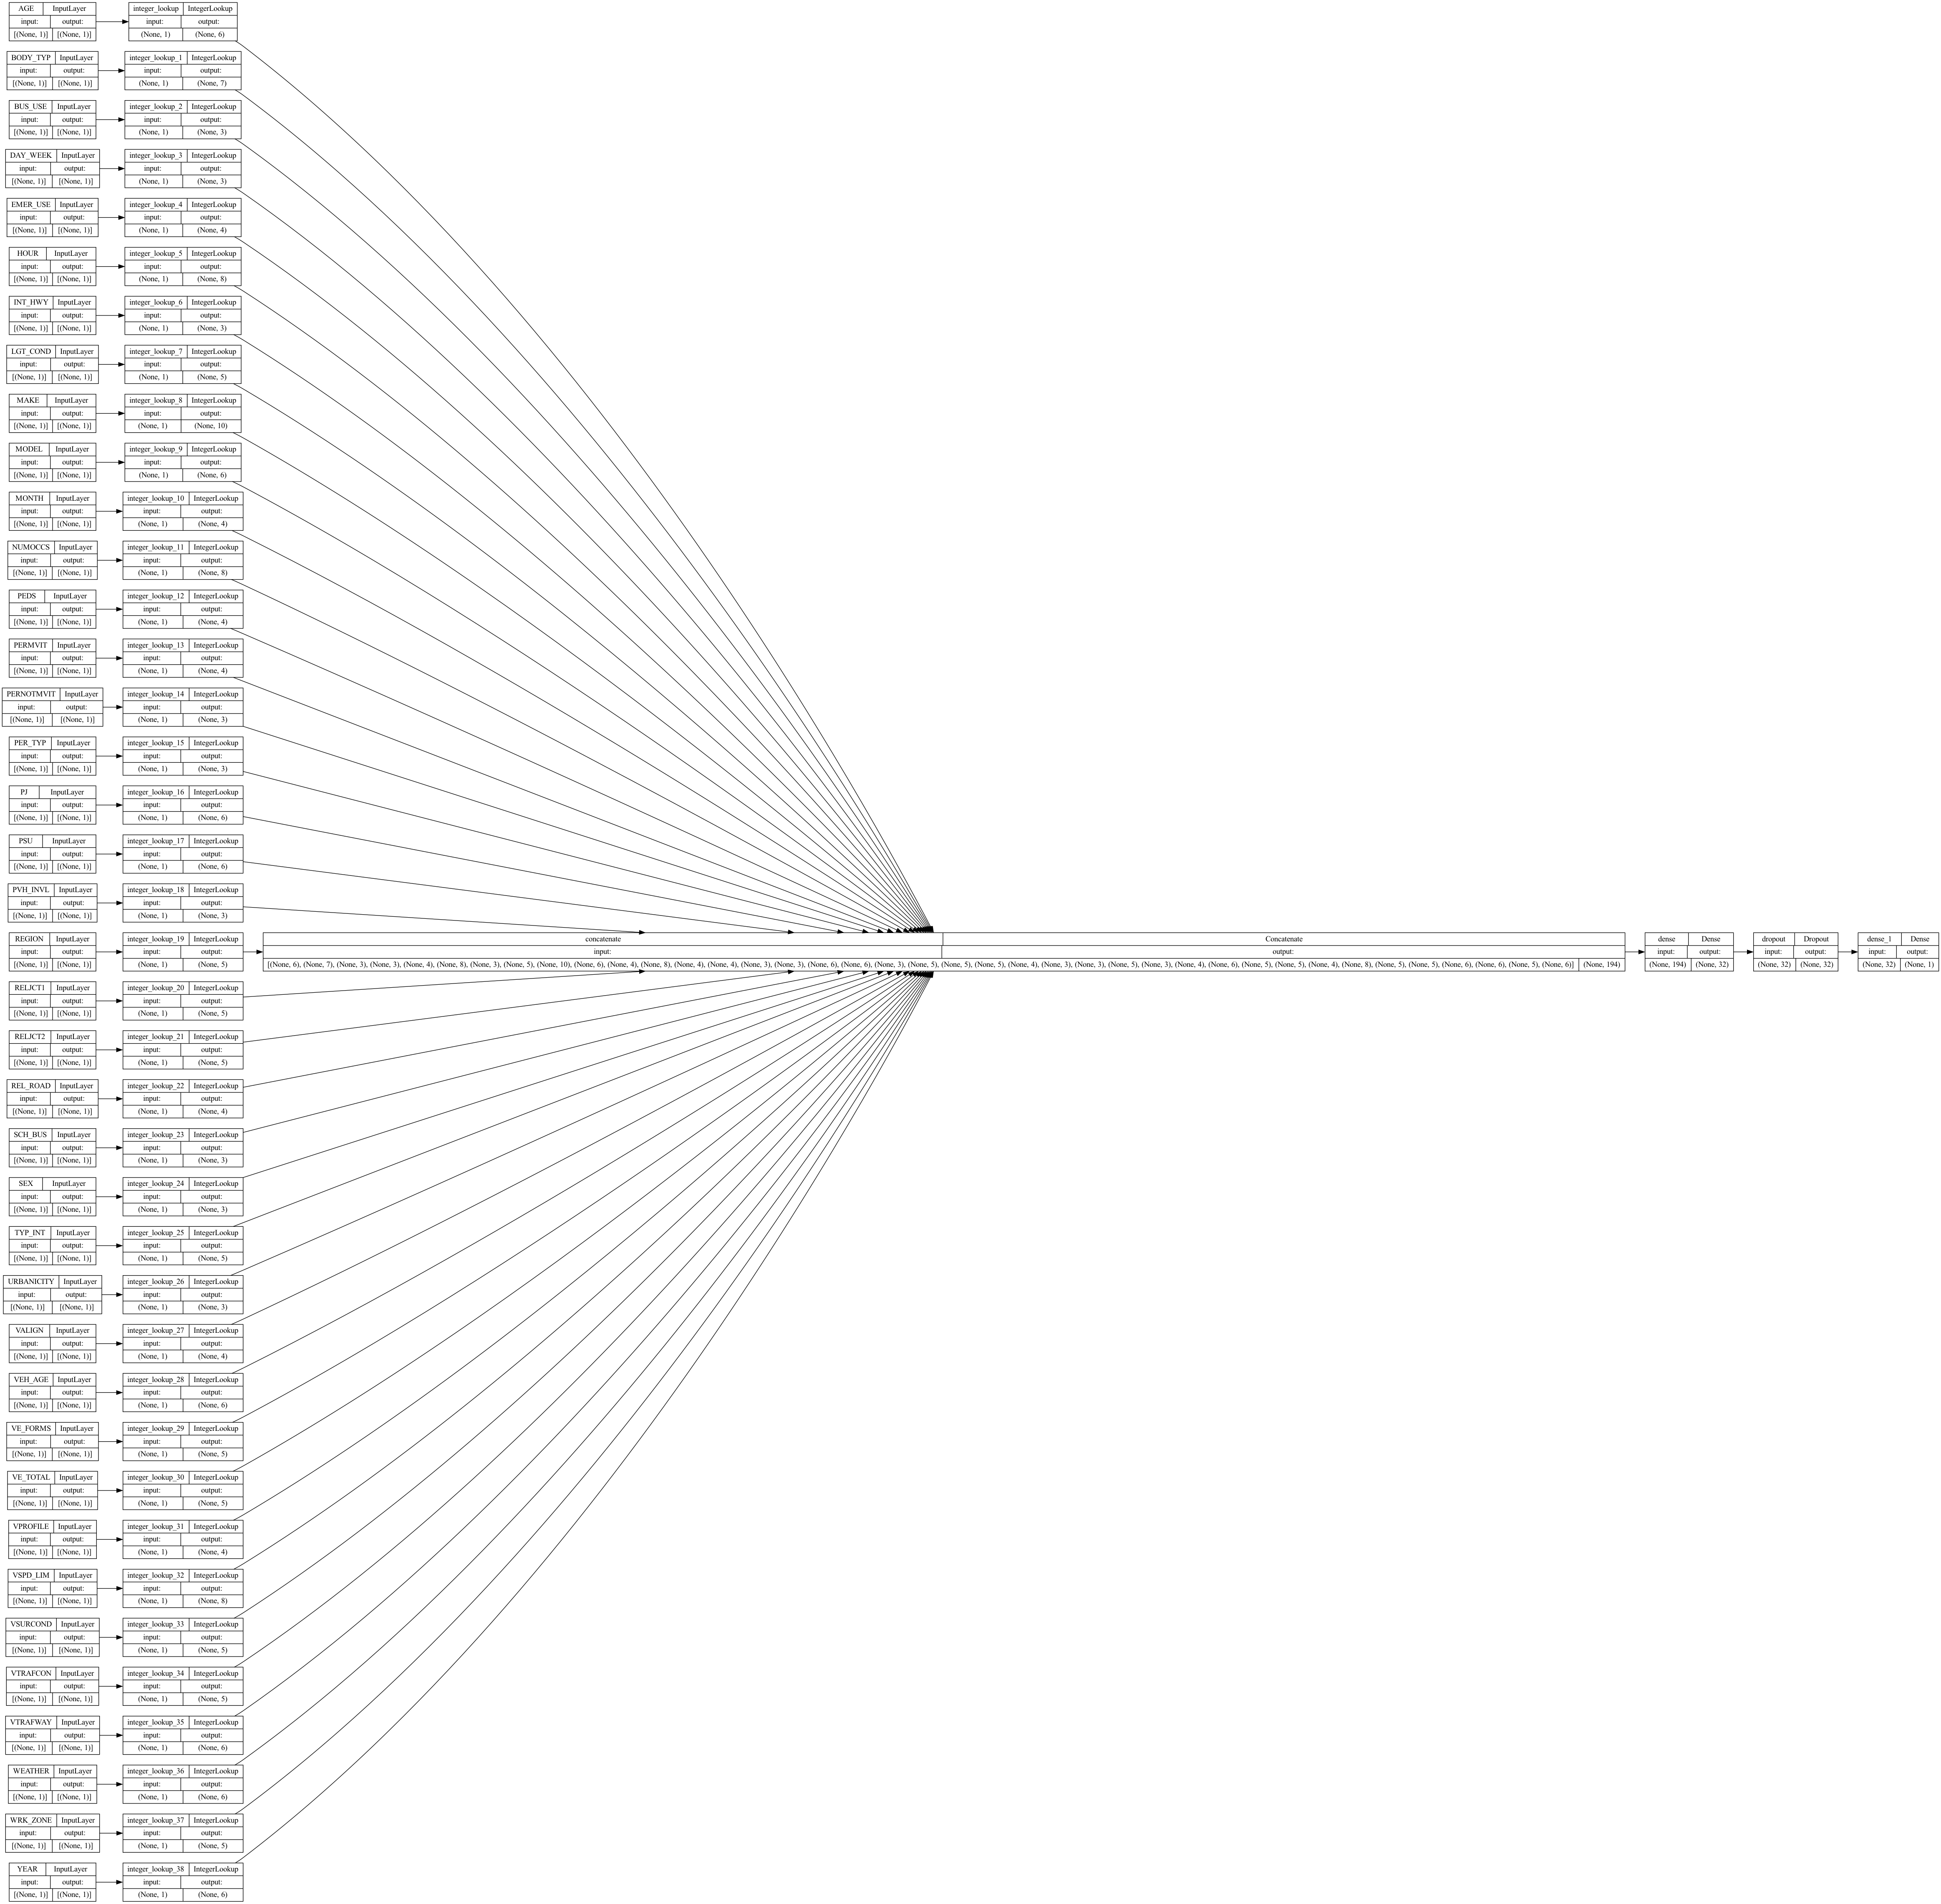

In [14]:
def Main():
    target = 'HOSPITAL'

    data = Get_Data()
    data = Thin_Features(data)
    for feature in data:
        print (feature)
    print ()
    
#    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
#    data = pd.read_csv(file_url)
#    target = 'target'
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.005)
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
    train_ds = Dataframe_to_Dataset(X_train, y_train)
    test_ds = Dataframe_to_Dataset(X_test, y_test)    
    # Before printing to check whether the thing is doing what we want it to do,
    # change the 'test_size' in Train_Test_Split to 0.01 or less.
    # Otherwise this print will take too long.  
#    print (list(test_ds.as_numpy_iterator())[0])
#    print ()

    train_ds = Batch(train_ds)
    test_ds = Batch(test_ds)
#    print (list(test_ds.as_numpy_iterator())[0])
#    print ()

    All_Inputs, All_Features = Encode_Features(X_test, test_ds)
    model = Make_Model (All_Inputs, All_Features)
    #Connectivity_Graph(model)
    
    return model
        
model = Main()

keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
